# Finance Project III — CAPM & FF3F on Ken French 5×5 (ME × BE/ME) Portfolios (Monthly)

This notebook:
- Downloads **Ken French** 5×5 portfolios (ME × BE/ME, monthly, value-weighted) and **FF3 factors**.
- Lets you set a **date range** and choose whether descriptives use **raw or excess** returns.
- Runs **Time-Series (TS)** tests for **CAPM** and **FF3F**:
  - Per portfolio: α, s.e.(α), t(α), β’s, R²; report **Average R²**; run **GRS** (joint α = 0).
- Runs **Fama–MacBeth (FMB)** cross-sectional pricing for **CAPM** and **FF3F** with rolling betas.
- Shows **clean tables** and **simple Matplotlib visuals** (no seaborn, one chart per figure, no custom colors).

In [1]:
import re
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.stats import f as f_dist
from scipy.stats import t as t_dist
from io import StringIO

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# ---------- small statistical helpers ----------
def monthly_sharpe(excess_series: pd.Series) -> float:
    s = excess_series.dropna()
    if s.shape[0] < 2:
        return np.nan
    mu = s.mean()
    sd = s.std(ddof=1)
    return np.nan if sd == 0 else mu / sd

def tstat_of_mean(series: pd.Series) -> float:
    s = series.dropna()
    T = s.shape[0]
    if T < 2:
        return np.nan
    mu = s.mean()
    sd = s.std(ddof=1)
    if sd == 0:
        return np.nan
    se = sd / np.sqrt(T)
    if se == 0:
        return np.nan
    return mu / se

def ols_with_const(y: pd.Series, X: pd.DataFrame):
    Xc = sm.add_constant(X)
    return sm.OLS(y, Xc, missing="drop").fit()

def grs_test_with_alphas(alphas, factor_means, factor_cov, residual_cov, T, N, L):
    """
    Gibbons–Ross–Shanken (1989) F-stat for joint α = 0 across N assets, L factors.
    Returns (F, pval).
    """
    a = np.asarray(alphas, dtype=float).reshape(-1, 1)
    m = np.asarray(factor_means, dtype=float).reshape(-1, 1)
    Sigma_f_inv = inv(np.asarray(factor_cov, dtype=float))
    Sigma_e_inv = inv(np.asarray(residual_cov, dtype=float))

    term = float(m.T @ Sigma_f_inv @ m)
    numer = T / N * (T - N - L) / (T - L - 1)
    denom = 1.0 + term

    F = numer * float(a.T @ Sigma_e_inv @ a) / denom
    df1, df2 = N, T - N - L
    if df2 <= 0:
        return np.nan, np.nan
    pval = 1.0 - f_dist.cdf(F, df1, df2)
    return F, pval

In [4]:
URL_FF3_MONTHLY = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip'
URL_KF_25_MONTHLY = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/25_Portfolios_5x5_CSV.zip'

FF3_MONTHLY_FILE_NAME = 'F-F_Research_Data_Factors.csv'
KF_25_MONTHLY_FILE_NAME = '25_Portfolios_5x5.csv'

FF3_L = 3
CAPM_L = 1

import requests, zipfile, os
from io import BytesIO

def download_and_save_kf_data(url: str, save_dir: str = "."):
    """
    Download Ken French dataset ZIP file, extract all CSV files, and save to the specified directory.

    Args:
        url (str): URL to the Ken French ZIP file.
        save_dir (str): Directory to save extracted CSVs (default: current folder).
    Returns:
        List of saved file paths.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    resp = requests.get(url)
    resp.raise_for_status()

    with zipfile.ZipFile(BytesIO(resp.content)) as z:
        saved_files = []
        for fname in z.namelist():
            if fname.endswith('.csv'):
                out_path = os.path.join(save_dir, os.path.basename(fname))
                with z.open(fname) as f_in, open(out_path, 'wb') as f_out:
                    f_out.write(f_in.read())
                saved_files.append(out_path)
    
    return saved_files

download_and_save_kf_data(URL_FF3_MONTHLY)
download_and_save_kf_data(URL_KF_25_MONTHLY)

['.\\25_Portfolios_5x5.csv']

## Robust CSV Readers
Ken French CSVs include header text and sometimes duplicate column labels.  
We:
- detect the **first `YYYYMM` row** (monthly table start),
- use the **line above** as the header,
- **deduplicate** header names (pandas requires unique names),
- parse **by commas** (so names with spaces stay intact),
- convert **percent → decimal**.

In [5]:
import pandas as pd
import numpy as np
import re
from io import StringIO

def _first_monthly_index_csv(lines):
    """
    Return the line index where monthly data start (first token YYYYMM), 
    assuming comma-separated rows.
    """
    for i, line in enumerate(lines):
        toks = [t.strip() for t in line.strip().split(",")]
        if len(toks) > 0 and toks[0].isdigit() and len(toks[0]) == 6:
            return i
    return None

def _dedupe(names):
    """
    Make column names unique by appending _1, _2, ... to duplicates.
    """
    out, seen = [], {}
    for n in names:
        n = (n or "").strip()
        if n == "":
            n = "COL"
        if n in seen:
            seen[n] += 1
            out.append(f"{n}_{seen[n]}")
        else:
            seen[n] = 0
            out.append(n)
    return out

def _align_header_to_ncols(header, ncols):
    """
    Ensure header length == ncols; pad or truncate as needed.
    """
    header = list(header)
    if len(header) < ncols:
        pad = [f"COL{j}" for j in range(len(header)+1, ncols+1)]
        header = header + pad
    elif len(header) > ncols:
        header = header[:ncols]
    return header

# ---------- read Ken French 25-portfolios (monthly) from CSV (no Path) ----------
def read_kf_25_csv(filename: str) -> pd.DataFrame:
    with open(filename, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    # Find the line index where the row contains 'Average Equal Weighted Returns -- Monthly'
    filter_start = None
    for i, line in enumerate(lines):
        if 'Average Equal Weighted Returns -- Monthly' in line:
            filter_start = i + 1  # start reading after this line
            break

    if filter_start is None:
        raise ValueError("Could not find line containing 'Average Equal Weighted Returns -- Monthly'")

    # Now find first monthly data index after this line
    start_idx = _first_monthly_index_csv(lines[filter_start:])
    if start_idx is None:
        raise ValueError("Could not locate YYYYMM data start in 25_Portfolios_5x5.csv")

    start_idx = start_idx + filter_start  # adjust relative to full lines

    # Find end index for data block: first empty line or where first token is not YYYYMM format
    end_idx = len(lines)
    for j in range(start_idx, len(lines)):
        first_token = lines[j].strip().split(",")[0]
        if not (first_token.isdigit() and len(first_token) == 6):
            end_idx = j
            break

    # Header is previous line; parse by commas (NOT whitespace)
    header_line = lines[start_idx - 1]
    header_raw = [t.strip() for t in header_line.strip().split(",")]

    # Detect ncols from the FIRST data row (comma-split)
    first_data_tokens = [t.strip() for t in lines[start_idx].strip().split(",")]
    ncols = len(first_data_tokens)

    # Force first column to 'YYYYMM'
    if not header_raw:
        header_raw = ["YYYYMM"]
    else:
        header_raw[0] = "YYYYMM"

    # align and dedupe
    header = _align_header_to_ncols(header_raw, ncols)
    header = _dedupe(header)

    # read the data block using comma separator with slice lines
    text = "".join(lines[start_idx:end_idx])
    df = pd.read_csv(StringIO(text), sep=",", engine="python", header=None, names=header)

    # keep only proper YYYYMM rows
    df = df[df["YYYYMM"].astype(str).str.isdigit()].copy()
    df["YYYYMM"] = df["YYYYMM"].astype(int)
    df["date"] = pd.to_datetime(df["YYYYMM"].astype(str) + "01", format="%Y%m%d") + pd.offsets.MonthEnd(0)

    # set index and drop YYYYMM
    df = df.set_index("date").drop(columns=["YYYYMM"])

    # keep first 25 portfolio columns (leftmost 25 after YYYYMM)
    keep_cols = list(df.columns)[:25]
    df = df[keep_cols].apply(pd.to_numeric, errors="coerce") / 100.0
    return df

# ---------- read FF factors (monthly only) from CSV (no Path) ----------
def read_ff3_monthly(filename: str) -> pd.DataFrame:
    with open(filename, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    # find where Annual section starts (truncate monthly section there)
    stop_idx = None
    for i, line in enumerate(lines):
        if "Annual" in line or "ANNUAL" in line:
            stop_idx = i
            break
    monthly_lines = lines if stop_idx is None else lines[:stop_idx]

    start_idx = _first_monthly_index_csv(monthly_lines)
    if start_idx is None:
        raise ValueError("Could not locate YYYYMM monthly start in F-F_Research_Data_Factors.csv")

    header_line = monthly_lines[start_idx - 1]
    header_raw = [t.strip() for t in header_line.strip().split(",")]
    first_data_tokens = [t.strip() for t in monthly_lines[start_idx].strip().split(",")]
    ncols = len(first_data_tokens)

    # first column
    if not header_raw:
        header_raw = ["YYYYMM"]
    else:
        header_raw[0] = "YYYYMM"

    header = _align_header_to_ncols(header_raw, ncols)
    header = _dedupe(header)

    text = "".join(monthly_lines[start_idx:])
    df = pd.read_csv(StringIO(text), sep=",", engine="python", header=None, names=header)

    # keep only monthly numeric rows
    df = df[df["YYYYMM"].astype(str).str.isdigit()].copy()
    df["YYYYMM"] = df["YYYYMM"].astype(int)
    df["date"] = pd.to_datetime(df["YYYYMM"].astype(str) + "01", format="%Y%m%d") + pd.offsets.MonthEnd(0)

    # rename factors to RMRF/SMB/HML/RF
    rename_map = {}
    for c in df.columns:
        cu = c.strip().upper()
        if "MKT" in cu: rename_map[c] = "RMRF"
        elif cu == "SMB": rename_map[c] = "SMB"
        elif cu == "HML": rename_map[c] = "HML"
        elif cu == "RF" : rename_map[c] = "RF"
    df = df.rename(columns=rename_map)

    keep = [c for c in ["date","RMRF","SMB","HML","RF"] if c in (["date"] + list(df.columns))]
    df = df[keep].set_index("date").sort_index()

    # numeric & % → decimal
    for c in [col for col in ["RMRF","SMB","HML","RF"] if col in df.columns]:
        df[c] = pd.to_numeric(df[c], errors="coerce") / 100.0
    return df

# ---------- read both files (filenames only) ----------
ret_5x5 = read_kf_25_csv(f'{KF_25_MONTHLY_FILE_NAME}')
ff3     = read_ff3_monthly(f'{FF3_MONTHLY_FILE_NAME}')

# align on common months
data = ret_5x5.join(ff3, how="inner")

print("Portfolios:", ret_5x5.shape, "| Factors:", ff3.shape)
print("Merged data range:", data.index.min().date(), "→", data.index.max().date())
data.head()

Portfolios: (1190, 25) | Factors: (1190, 4)
Merged data range: 1926-07-31 → 2025-08-31


,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM,RMRF,SMB,HML,RF
date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.066093,-0.040865,-0.000429,0.011716,-0.014577,0.016951,0.018125,0.001750,-0.025128,-0.010845,...,0.026443,0.047298,0.037848,0.014997,0.039874,0.013568,0.0289,-0.0255,-0.0239,0.0022
1926-08-31,-0.002185,-0.050680,0.006545,0.037326,0.061829,0.018013,-0.011506,0.038679,0.000411,0.054438,...,0.057585,0.001742,0.028668,0.025618,0.045299,0.064265,0.0264,-0.0114,0.0381,0.0025
1926-09-30,-0.084180,-0.038457,-0.038560,-0.058837,0.048919,-0.035551,-0.003247,0.013000,-0.027563,-0.020148,...,-0.003495,-0.013635,0.012336,0.004175,-0.010864,-0.026329,0.0038,-0.0136,0.0005,0.0023
1926-10-31,-0.083217,-0.042445,-0.069964,0.023415,-0.036554,-0.045372,-0.033920,-0.047092,-0.079607,-0.019664,...,-0.060402,-0.026837,-0.027187,-0.036805,-0.036642,-0.066019,-0.0327,-0.0014,0.0082,0.0032
1926-11-30,0.007153,0.054507,0.015352,-0.036596,0.025351,-0.004580,-0.024352,0.027419,0.058661,0.019119,...,0.016978,0.045427,0.036599,0.033339,0.025422,0.023429,0.0254,-0.0011,-0.0061,0.0031


## Load Data & Choose Sample
- `load_data()` reads both CSVs and aligns them by date.
- `get_sample()` subsets to the user’s start/end and builds **excess returns** (portfolio − RF).
- Portfolio names are optionally standardized to `MEi_BMj` for readability.

In [6]:
def normalize_port_names(cols):
        out = []
        for c in cols:
            s = str(c).strip()
            s = s.replace("SMALL", "ME1").replace("BIG", "ME5")
            s = s.replace("LoBM", "BM1").replace("HiBM", "BM5")
            s = re.sub(r"\s+", " ", s).upper()
            s = s.replace(" ", "_")
            out.append(s)
        return out

def normalize_and_rename_portfolios(data):
    
    factor_cols = [c for c in ["RMRF", "SMB", "HML", "RF"] if c in data.columns]
    port_cols = [c for c in data.columns if c not in factor_cols]
    
    new_port_cols = normalize_port_names(port_cols)
    data = data.rename(columns={old: new for old, new in zip(port_cols, new_port_cols)})
    
    # Re-calculate factor_cols and port_cols with updated names
    factor_cols = [c for c in ["RMRF", "SMB", "HML", "RF"] if c in data.columns]
    port_cols = [c for c in data.columns if c not in factor_cols]

    return data, factor_cols, port_cols

data, factor_cols, port_cols = normalize_and_rename_portfolios(data)

## User Inputs

- `start`, `end` — inclusive sample window (YYYY-MM).
- `use_raw_for_descriptives` — True ⇒ descriptives on raw returns (TS/FMB always use **excess**).
- `fmb_beta_window` — rolling months for FMB betas.

In [7]:
import re
from datetime import datetime

def prompt_date_range(dates):
    """
    Prompt user for a start and end date, normalize to YYYY-MM endpoints, and validate against the given date index.
    Keeps looping until valid input is given for both.
    """
    min_date = dates.min()
    max_date = dates.max()

    def normalize_date(s):
        """Try to convert user input to 'YYYY-MM' or Timestamp."""
        s = s.strip()
        patterns = [
            ("%Y-%m", r"^\d{4}-\d{2}$"),
            ("%m/%Y", r"^\d{2}/\d{4}$"),
            ("%Y%m",  r"^\d{6}$"),
            ("%b-%Y", r"^[A-Za-z]{3}-\d{4}$"),
            ("%B-%Y", r"^[A-Za-z]+-\d{4}$"),
        ]
        for fmt, pat in patterns:
            if re.match(pat, s):
                try:
                    return pd.to_datetime(datetime.strptime(s, fmt)), None
                except Exception:
                    return None, f"Could not parse '{s}'"
        try:
            return pd.to_datetime(s), None
        except Exception:
            return None, f"Could not parse '{s}'"

    while True:
        start_input = input(f"Enter start date on or after {min_date.strftime('%Y-%m')} (e.g., 2010-01): ").strip()
        start, err_start = normalize_date(start_input)
        if err_start:
            print(err_start)
            continue  # Invalid start date, retry

        end_input = input(f"Enter end date on or before {max_date.strftime('%Y-%m')} (e.g., 2023-12): ").strip()
        end, err_end = normalize_date(end_input)
        if err_end:
            print(err_end)
            continue  # Invalid end date, retry

        if end < start:
            print("End date must be after or equal to start date.")
            continue  # Retry on inverted range

        if start < min_date or end > max_date:
            print(f"Date range must be within {min_date.strftime('%Y-%m')} and {max_date.strftime('%Y-%m')}.")
            continue  # Retry on out of range

        # Normalize to month end
        start = pd.to_datetime(start) + pd.offsets.MonthEnd(0)
        end = pd.to_datetime(end) + pd.offsets.MonthEnd(0)

        print(f"Validated date range: {start.date()} to {end.date()}")
        return start, end
        

def prompt_model_choice():
    """
    Prompt user for model choice. Options: CAPM, FF3F, Both (case-insensitive).
    Returns:
        One of: 'CAPM', 'FF3F', 'Both'
    """
    valid = {"capm": "CAPM", "ff3f": "FF3F", "both": "Both"}
    while True:
        inp = input("Choose model (CAPM, FF3F, Both): ").strip().lower()
        if inp in valid:
            print(f"Selected model: {valid[inp]}")
            return valid[inp]
        print("Invalid option. Please type CAPM, FF3F, or Both.")

start, end = prompt_date_range(data.index)
model = prompt_model_choice()

Validated date range: 1963-01-31 to 1993-12-31
Selected model: Both


In [8]:
# # sample window
# start = "1963-01"
# end   = "1993-12"

# model = "Both"  # "CAPM", "FF3F", or "Both"

# descriptive stats mode
use_raw_for_descriptives = False   # True to show Mean/StdDev on raw returns

# subset and rebuild lists
sample = data.loc[
    (data.index >= pd.to_datetime(start) + pd.offsets.MonthEnd(0)) &
    (data.index <= pd.to_datetime(end)   + pd.offsets.MonthEnd(0))
].copy()

factor_cols = [c for c in ["RMRF","SMB","HML","RF"] if c in sample.columns]
port_cols   = [c for c in sample.columns if c not in factor_cols]

# EXCESS returns for 25 portfolios
excess = sample[port_cols].sub(sample["RF"], axis=0)

print("Sample window:", sample.index.min().date(), "→", sample.index.max().date())
print("# portfolios:", len(port_cols), "| factors:", factor_cols)

Sample window: 1963-01-31 → 1993-12-31
# portfolios: 25 | factors: ['RMRF', 'SMB', 'HML', 'RF']


## Descriptive Statistics (per portfolio)

For each portfolio *i* we report:

- Mean return $E[r_i]$  
- Standard deviation $\sigma_i$  
- Sharpe ratio $SR_i = \frac{E[r_i - r_f]}{\sigma_i}$  
- *t-statistic of mean excess return* $t(E[r_i - r_f]) = \frac{E[r_i - r_f]}{s(r_i - r_f)/\sqrt{T}}$

In [9]:
def calculate_descriptive_statistics(sample, port_cols, excess, use_raw_for_descriptives):
    base_for_stats = sample[port_cols] if use_raw_for_descriptives else excess
    rows = []
    for p in port_cols:
        rows.append({
            "Portfolio": p,
            "Mean (monthly)": base_for_stats[p].mean(),
            "StdDev (monthly)": base_for_stats[p].std(ddof=1),
            "Sharpe (monthly)": monthly_sharpe(excess[p]),
            "t(mean excess)": tstat_of_mean(excess[p]),
        })
    desc_table_monthly = pd.DataFrame(rows).set_index("Portfolio")

    desc_table_yearly = pd.DataFrame(index=desc_table_monthly.index)
    desc_table_yearly["Mean (yearly)"] = desc_table_monthly["Mean (monthly)"] * 12
    desc_table_yearly["StdDev (yearly)"] = desc_table_monthly["StdDev (monthly)"] * np.sqrt(12)
    desc_table_yearly["Sharpe (yearly)"] = desc_table_monthly["Sharpe (monthly)"] * np.sqrt(12)
    desc_table_yearly["t(mean excess)"] = desc_table_monthly["t(mean excess)"].copy()
    return desc_table_monthly, desc_table_yearly

desc_stats_monthly, desc_stats_yearly = calculate_descriptive_statistics(sample, port_cols, excess, use_raw_for_descriptives)
# desc_stats

## Time-Series CAPM

We estimate for each portfolio *i*:

$$
r_{i,t} - r_{f,t} = \alpha_i + \beta_i (R_{M,t} - r_{f,t}) + \varepsilon_{i,t}
$$

Reported statistics:

- $\alpha_i$, $SE(\alpha_i)$, $t(\alpha_i)$  
- $\beta_i$, $SE(\beta_i)$, $t(\beta_i)$  
- $R_i^2$, Average $R^2$ across portfolios  
- GRS test for joint $\alpha_i = 0$ across all assets

In [10]:
def cov_div_T_minus_L(X, L):
    T = X.shape[0]
    # Center data
    X_centered = X - X.mean(axis=0)
    # Compute covariance matrix with divisor T-L
    cov_mat = (X_centered.T @ X_centered) / (T - L)
    return cov_mat


In [ ]:
def run_capm_regression(sample, port_cols, excess, CAPM_L):
    capm_rows, alphas_capm, resids_capm = [], [], []
    X_capm = sample[["RMRF"]]
    T_capm = sample.shape[0]
    N_capm = len(port_cols)
    L_capm = CAPM_L

    for p in port_cols:
        y = excess[p]
        m = ols_with_const(y, X_capm)

        a    = m.params.get("const", np.nan)
        b    = m.params.get("RMRF", np.nan)
        se_a = m.bse.get("const", np.nan)
        se_b = m.bse.get("RMRF", np.nan)
        t_a  = m.tvalues.get("const", np.nan)
        t_b  = m.tvalues.get("RMRF", np.nan)
        r2   = m.rsquared

        capm_rows.append({
            "Portfolio": p,
            "Alpha": a, "SE(Alpha)": se_a, "t(Alpha)": t_a,
            "Beta_MKT": b, "SE(Beta_MKT)": se_b, "t(Beta_MKT)": t_b,
            "R2": r2
        })
        alphas_capm.append(a)
        resids_capm.append(m.resid)

    capm_table = pd.DataFrame(capm_rows).set_index("Portfolio")
    avg_r2_capm = capm_table["R2"].mean()

    # residual covariance (N×N)
    resid_mat_capm = pd.DataFrame({p: resids_capm[i] for i, p in enumerate(port_cols)}).dropna()
    Sigma_e_capm   = cov_div_T_minus_L(resid_mat_capm, L_capm)

    # factor means/cov
    f_means_capm = [sample["RMRF"].mean()]
    f_cov_capm   = cov_div_T_minus_L(sample[["RMRF"]], L_capm)

    GRS_capm, p_capm = grs_test_with_alphas(alphas_capm, f_means_capm, f_cov_capm, Sigma_e_capm, T_capm, N_capm, L_capm)

    capm_summary = pd.DataFrame({
        "Average R2": [avg_r2_capm],
        "GRS (CAPM)": [GRS_capm],
        "p-value": [p_capm],
        "Conclusion": ["Reject Null" if p_capm <= 0.05 else "Do Not Reject Null"],
        "T": [T_capm],
        "N": [N_capm]
    })
    capm_summary.reset_index(drop=True, inplace=True)
    # Name the row for clarity
    capm_summary.index = ["CAPM"]

    return capm_table, capm_summary, f_cov_capm, Sigma_e_capm

capm_table, capm_summary, f_cov_capm, Sigma_e_capm = run_capm_regression(sample, port_cols, excess, CAPM_L)
# display(capm_table)
# display(capm_summary)

## Time-Series FF3F

We estimate:

$$
r_{i,t} - r_{f,t} = \alpha_i + b_{MKT} RMRF_t + b_{SMB} SMB_t + b_{HML} HML_t + \varepsilon_{i,t}
$$

Reported:

- $\alpha_i$, $t(\alpha_i)$, and $R_i^2$  
- Three factor loadings ($b_{MKT}$, $b_{SMB}$, $b_{HML}$) with standard errors and *t*-values  
- Average $R^2$ and GRS for joint $\alpha=0$

In [ ]:
def run_ff3f_regression(sample, port_cols, excess, FF3_L):
    ff3_rows, alphas_ff3, resids_ff3 = [], [], []
    X_ff3 = sample[["RMRF", "SMB", "HML"]]

    T_ff3 = sample.shape[0]
    N_ff3 = len(port_cols)
    L_ff3 = FF3_L

    for p in port_cols:
        y = excess[p]
        m = ols_with_const(y, X_ff3)

        a     = m.params.get("const", np.nan)
        b_mkt = m.params.get("RMRF", np.nan)
        b_smb = m.params.get("SMB",  np.nan)
        b_hml = m.params.get("HML",  np.nan)

        se_a  = m.bse.get("const", np.nan)
        se_m  = m.bse.get("RMRF",  np.nan)
        se_s  = m.bse.get("SMB",   np.nan)
        se_h  = m.bse.get("HML",   np.nan)

        t_a   = m.tvalues.get("const", np.nan)
        t_m   = m.tvalues.get("RMRF",  np.nan)
        t_s   = m.tvalues.get("SMB",   np.nan)
        t_h   = m.tvalues.get("HML",   np.nan)

        r2    = m.rsquared

        ff3_rows.append({
            "Portfolio": p,
            "Alpha": a, "SE(Alpha)": se_a, "t(Alpha)": t_a,
            "Beta_MKT": b_mkt, "SE(Beta_MKT)": se_m, "t(Beta_MKT)": t_m,
            "Beta_SMB": b_smb, "SE(Beta_SMB)": se_s, "t(Beta_SMB)": t_s,
            "Beta_HML": b_hml, "SE(Beta_HML)": se_h, "t(Beta_HML)": t_h,
            "R2": r2
        })
        alphas_ff3.append(a)
        resids_ff3.append(m.resid)

    ff3_table = pd.DataFrame(ff3_rows).set_index("Portfolio")
    avg_r2_ff3 = ff3_table["R2"].mean()

    # residual covariance
    resid_mat_ff3 = pd.DataFrame({p: resids_ff3[i] for i, p in enumerate(port_cols)}).dropna()
    Sigma_e_ff3   = cov_div_T_minus_L(resid_mat_ff3, L_ff3)

    # factor moments
    f_means_ff3 = sample[["RMRF", "SMB", "HML"]].mean().values
    f_cov_ff3   = cov_div_T_minus_L(sample[["RMRF", "SMB", "HML"]], L_ff3)

    GRS_ff3, p_ff3 = grs_test_with_alphas(alphas_ff3, f_means_ff3, f_cov_ff3, Sigma_e_ff3, T_ff3, N_ff3, L_ff3)

    ff3_summary = pd.DataFrame({
        "Average R2": [avg_r2_ff3],
        "GRS (FF3F)": [GRS_ff3],
        "p-value": [p_ff3],
        "Conclusion": ["Reject Null" if p_ff3 <= 0.05 else "Do Not Reject Null"],
        "T": [T_ff3],
        "N": [N_ff3]
    })
    ff3_summary.reset_index(drop=True, inplace=True)
    # Name the row for clarity
    ff3_summary.index = ["FF3F"]

    return ff3_table, ff3_summary, f_cov_ff3, Sigma_e_ff3


ff3_table, ff3_summary, f_cov_ff3, Sigma_e_ff3 = run_ff3f_regression(sample, port_cols, excess, FF3_L)
# display(ff3_table)
# display(ff3_summary)

## Cross-Sectional Fama–MacBeth (FMB)

**CAPM pricing regression**
$$
r_{i,t}^{excess} = \lambda_{0,t} + \lambda_{MKT,t}\,\beta_{i,MKT} + \epsilon_{i,t}
$$

**FF3F pricing regression**
$$
r_{i,t}^{excess} = \lambda_{0,t} + \lambda_{MKT,t}\,\beta_{i,MKT} + \lambda_{SMB,t}\,\beta_{i,SMB} + \lambda_{HML,t}\,\beta_{i,HML} + \epsilon_{i,t}
$$

3. Average each $\lambda$ over time and report its mean, standard error, and *t-statistic*:

$$
t(\bar{\lambda}_k) = \frac{\bar{\lambda}_k}{s(\lambda_{k,t}) / \sqrt{T}}
$$

In [13]:
def fmb_procedure(excess_returns: pd.DataFrame, betas: pd.DataFrame) -> pd.DataFrame:
    """
    Fama-MacBeth procedure for estimating risk premia.
    1. For each time period t, run cross-sectional regression of excess returns on betas to estimate risk premia.
    2. Obtain time series of risk premia estimates and compute their means, standard errors, and t-stats.
    3. Return a summary DataFrame with the results.

    Parameters:
    - excess_returns: pd.DataFrame, shape (T, N), excess returns for N assets over T periods
    - betas: pd.DataFrame, shape (N, K), factor loadings (betas)

    Returns:
    - summary_df: pd.DataFrame with columns [Mean, StdErr, t-Stat] indexed by factor name (+ Alpha).
    """
    T, N = excess_returns.shape
    K = betas.shape[1]

    risk_premia_estimates = []

    for t in range(T):
        y = excess_returns.iloc[t].values  # returns at time t (length N)
        X = betas.values  # shape (N, K)

        # Add constant (intercept) term
        m = ols_with_const(y, pd.DataFrame(X))

        lambda_t = m.params
        # Append parameters including intercept
        risk_premia_estimates.append(lambda_t.values if lambda_t is not None else [np.nan] * (K + 1))

    risk_premia_estimates = np.array(risk_premia_estimates)  # shape (T, K+1)

    # Compute time-series mean, std error, and t-stats
    mean_lambda = np.nanmean(risk_premia_estimates, axis=0)
    std_err_lambda = np.nanstd(risk_premia_estimates, axis=0, ddof=1) / np.sqrt(np.sum(~np.isnan(risk_premia_estimates), axis=0))
    t_stats = mean_lambda / std_err_lambda
    pval = 2 * (1 - t_dist.cdf(np.abs(t_stats), df=T-1))

    # Add "Alpha" as intercept name + factor names
    factor_names = ["Alpha"] + list(betas.columns)

    summary_df = pd.DataFrame({
        "Mean": mean_lambda,
        "StdErr": std_err_lambda,
        "t-Stat": t_stats,
        "p-value": pval,
    }, index=factor_names)

    return summary_df


# CAPM betas (constant)
betas_capm = capm_table[["Beta_MKT"]]
fmb_capm_summary = fmb_procedure(excess, betas_capm)
# display(fmb_capm_summary)

# FF3F betas (constant)
betas_ff3 = ff3_table[["Beta_MKT", "Beta_SMB", "Beta_HML"]]
fmb_ff3_summary = fmb_procedure(excess, betas_ff3)
# display(fmb_ff3_summary)

## Shanken correction for FMB estimation

$$
\text{SE}(\hat{\lambda})_{\text{Shanken}} = \text{SE}(\hat{\lambda})_{\text{FMB}} \times \sqrt{1 + \hat{\lambda}^\top \Sigma_F^{-1} \hat{\lambda}}
$$

$$
t(\hat{\lambda}_k)_{\text{Shanken}} = \frac{\hat{\lambda}_k}{\text{SE}(\hat{\lambda}_k)_{\text{Shanken}}}
$$

In [14]:
def shanken_correction(summary_df: pd.DataFrame, factor: pd.DataFrame) -> pd.DataFrame:
    '''
    Apply the Shanken correction to the standard errors and t-stats of risk premia estimates,
    including the alpha (intercept).

    Parameters:
    - summary_df: DataFrame with columns ['Mean', 'StdErr', 't-Stat'] indexed by factor names,
                  first index is assumed 'Alpha'.
    - factor: DataFrame of factor returns (T x K).

    Returns:
    - corrected_summary_df: DataFrame with updated 'StdErr' and 't-Stat'.
    '''
    L = factor.shape[1]
    T = factor.shape[0]

    factorcovmat = cov_div_T_minus_L(factor, L)  # shape (L, L)

    # Extract means of all lambdas including alpha
    # Assume index order: alpha first, then factors
    lambdas_all = summary_df["Mean"].values.reshape(-1, 1)  # (L+1,1)
    
    # Separate alpha and factor lambdas
    alpha_lambda = lambdas_all[0:1]              # shape (1,1)
    factor_lambdas = lambdas_all[1:]             # shape (L,1)

    # Compute correction term for factors only
    inv_factorcov = np.linalg.inv(factorcovmat)
    factor_correction = 1 + (factor_lambdas.T @ inv_factorcov @ factor_lambdas).item()

    # Apply the same correction factor to alpha and factor std errors
    corrected_std_err = summary_df["StdErr"] * np.sqrt(factor_correction)
    corrected_t_stat = summary_df["Mean"] / corrected_std_err

    corrected_summary_df = summary_df.copy()
    corrected_summary_df["StdErr"] = corrected_std_err
    corrected_summary_df["t-Stat"] = corrected_t_stat
    corrected_summary_df["p-value"] = 2 * (1 - t_dist.cdf(np.abs(corrected_t_stat), df=T-1))

    return corrected_summary_df

fmb_capm_summary_shanken = shanken_correction(fmb_capm_summary, sample[["RMRF"]])
# display(fmb_capm_summary_shanken)

fmb_ff3_summary_shanken = shanken_correction(fmb_ff3_summary, sample[["RMRF","SMB","HML"]])
# display(fmb_ff3_summary_shanken)


In [15]:
def aggregate_results(fmb_summary: pd.DataFrame, fmb_summary_shanken: pd.DataFrame) -> pd.DataFrame:
    """
    Combine Fama-MacBeth summary and Shanken-corrected summary into a single DataFrame for display.
    """
    agg = fmb_summary.copy()
    agg.columns = [f"{col} (uncorrected)" for col in agg.columns]
    shanken_cols = {col: f"{col} (Shanken)" for col in fmb_summary_shanken.columns}
    agg = agg.join(fmb_summary_shanken.rename(columns=shanken_cols))
    return agg

agg_capm = aggregate_results(fmb_capm_summary, fmb_capm_summary_shanken)
# display(agg_capm)
agg_ff3 = aggregate_results(fmb_ff3_summary, fmb_ff3_summary_shanken)
# display(agg_ff3)

## Visuals (MPL defaults)

- **Alpha bars:** display $\alpha_i$ for CAPM and FF3F.  
- **R² scatter:** compare $R_i^2$(CAPM) vs $R_i^2$(FF3F).  
- **FMB λ plots:** plot $\bar{\lambda}_k$ with ±1 standard error bars.

In [16]:
import matplotlib.pyplot as plt

def plot_capm_alpha_bars(capm_table):
    fig, ax = plt.subplots()
    capm_table["Alpha"].sort_values().plot(kind="barh", ax=ax)
    ax.set_title("CAPM Alphas by Portfolio (monthly)")
    ax.set_xlabel("Alpha")
    fig.tight_layout()
    return fig

def plot_ff3f_alpha_bars(ff3_table):
    fig, ax = plt.subplots()
    ff3_table["Alpha"].sort_values().plot(kind="barh", ax=ax)
    ax.set_title("FF3F Alphas by Portfolio (monthly)")
    ax.set_xlabel("Alpha")
    fig.tight_layout()
    return fig

def plot_r2_scatter_capm_vs_ff3f(capm_table, ff3_table):
    fig, ax = plt.subplots()
    x = capm_table["R2"]
    y = ff3_table["R2"]
    ax.scatter(x, y)
    minv = float(min(x.min(), y.min()))
    maxv = float(max(x.max(), y.max()))
    ax.plot([minv, maxv], [minv, maxv])  # 45-degree line
    ax.set_title("R²: CAPM vs FF3F (per portfolio)")
    ax.set_xlabel("R² CAPM")
    ax.set_ylabel("R² FF3F")
    fig.tight_layout()
    return fig

def plot_fmb_capm_lambdas(fmb_capm_summary):
    fig, ax = plt.subplots()
    s = fmb_capm_summary.loc[["Alpha", "Beta_MKT"]]
    x_pos = [0.5, 1.5]
    ax.errorbar(x_pos, s["Mean"], yerr=s["StdErr"], fmt='o')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(s.index, rotation=0)
    ax.set_xlim(0, 2)
    ax.set_title("FMB CAPM — Lambda Means with StdErr")
    fig.tight_layout()
    return fig

def plot_fmb_ff3f_lambdas(fmb_ff3_summary):
    fig, ax = plt.subplots()
    s = fmb_ff3_summary.loc[["Alpha", "Beta_MKT", "Beta_SMB", "Beta_HML"]]
    ax.errorbar(range(s.shape[0]), s["Mean"], yerr=s["StdErr"], fmt='o')
    ax.set_xticks(range(s.shape[0]))
    ax.set_xticklabels(s.index, rotation=0)
    ax.set_title("FMB FF3F — Lambda Means with StdErr")
    fig.tight_layout()
    return fig

# plot1 = plot_capm_alpha_bars(capm_table)
# plot2 = plot_ff3f_alpha_bars(ff3_table)
# plot3= plot_r2_scatter_capm_vs_ff3f(capm_table, ff3_table)
# plot4 = plot_fmb_capm_lambdas(fmb_capm_summary)
# plot5 = plot_fmb_ff3f_lambdas(fmb_ff3_summary)

Descriptive Statistics of Portfolios (Yearly):


,Mean (yearly),StdDev (yearly),Sharpe (yearly),t(mean excess)
Portfolio,,,,
ME1_BM1,0.068451,0.270970,0.252616,1.406505
ME1_BM2,0.106896,0.242280,0.441207,2.456539
ME1_BM3,0.119326,0.225883,0.528265,2.941254
ME1_BM4,0.139087,0.216206,0.643309,3.581795
ME1_BM5,0.168567,0.224410,0.751156,4.182261
ME2_BM1,0.041358,0.251435,0.164489,0.915833
ME2_BM2,0.083138,0.215957,0.384974,2.143447
ME2_BM3,0.108906,0.197075,0.552612,3.076813
ME2_BM4,0.116002,0.183039,0.633755,3.528598



Descriptive Statistics of Portfolios (Monthly):


,Mean (monthly),StdDev (monthly),Sharpe (monthly),t(mean excess)
Portfolio,,,,
ME1_BM1,0.005704,0.078222,0.072924,1.406505
ME1_BM2,0.008908,0.069940,0.127366,2.456539
ME1_BM3,0.009944,0.065207,0.152497,2.941254
ME1_BM4,0.011591,0.062413,0.185707,3.581795
ME1_BM5,0.014047,0.064782,0.216840,4.182261
ME2_BM1,0.003447,0.072583,0.047484,0.915833
ME2_BM2,0.006928,0.062341,0.111133,2.143447
ME2_BM3,0.009076,0.056891,0.159525,3.076813
ME2_BM4,0.009667,0.052839,0.182949,3.528598



CAPM Regression Results:


,Alpha,SE(Alpha),t(Alpha),Beta_MKT,SE(Beta_MKT),t(Beta_MKT),R2
Portfolio,,,,,,,
ME1_BM1,-0.000281,0.002604,-0.108016,1.353653,0.058313,23.213497,0.592899
ME1_BM2,0.003580,0.002343,1.527781,1.204871,0.052480,22.958806,0.587563
ME1_BM3,0.004965,0.002178,2.280093,1.125924,0.048766,23.088240,0.590285
ME1_BM4,0.006913,0.002138,3.232875,1.057908,0.047884,22.092966,0.568814
ME1_BM5,0.009458,0.002371,3.989990,1.037801,0.053085,19.549714,0.508104
ME2_BM1,-0.002928,0.001772,-1.651814,1.441553,0.039692,36.318898,0.780944
ME2_BM2,0.001428,0.001497,0.953946,1.243933,0.033517,37.113574,0.788259
ME2_BM3,0.004109,0.001418,2.897499,1.123225,0.031756,35.370169,0.771753
ME2_BM4,0.005088,0.001349,3.770629,1.035545,0.030217,34.270120,0.760431



CAPM GRS Test Summary:


,Average R2,GRS (CAPM),p-value,Conclusion,T,N
CAPM,0.76888,2.839827,0.000012,Reject,372,25



FMB CAPM Summary (with Shanken correction):


,Mean (uncorrected),StdErr (uncorrected),t-Stat (uncorrected),p-value (uncorrected),Mean (Shanken),StdErr (Shanken),t-Stat (Shanken),p-value (Shanken)
Alpha,0.015610,0.004014,3.888315,0.000120,0.015610,0.004067,3.838299,0.000146
Beta_MKT,-0.007207,0.004577,-1.574615,0.116198,-0.007207,0.004636,-1.554360,0.120951



FF3F Regression Results:


,Alpha,SE(Alpha),t(Alpha),Beta_MKT,SE(Beta_MKT),t(Beta_MKT),Beta_SMB,SE(Beta_SMB),t(Beta_SMB),Beta_HML,SE(Beta_HML),t(Beta_HML),R2
Portfolio,,,,,,,,,,,,,
ME1_BM1,-0.002822,0.001423,-1.983509,0.981689,0.035245,27.853639,1.598866,0.052068,30.707106,-0.038221,0.057512,-0.664577,0.885733
ME1_BM2,-0.000251,0.001070,-0.234647,0.907305,0.026509,34.225912,1.500304,0.039163,38.308908,0.221380,0.043258,5.117678,0.919139
ME1_BM3,0.000452,0.000927,0.487613,0.886816,0.022958,38.627850,1.382003,0.033917,40.746886,0.378834,0.037463,10.112245,0.930228
ME1_BM4,0.001953,0.000840,2.325053,0.843302,0.020812,40.519080,1.352124,0.030747,43.975594,0.467263,0.033962,13.758483,0.937412
ME1_BM5,0.003253,0.001054,3.085493,0.853207,0.026114,32.672298,1.401615,0.038579,36.330594,0.673633,0.042613,15.808132,0.908537
ME2_BM1,-0.002518,0.000827,-3.046315,1.110270,0.020475,54.226596,1.095276,0.030248,36.209788,-0.408415,0.033411,-12.224118,0.955212
ME2_BM2,-0.000596,0.000692,-0.861146,1.036998,0.017131,60.533689,0.964492,0.025308,38.109767,0.064144,0.027954,2.294617,0.957498
ME2_BM3,0.001132,0.000651,1.738270,0.974573,0.016131,60.417617,0.880217,0.023830,36.936650,0.259477,0.026322,9.857791,0.954750
ME2_BM4,0.000975,0.000596,1.635471,0.968055,0.014769,65.547956,0.739239,0.021818,33.881512,0.504572,0.024100,20.937022,0.956028



FF3F GRS Test Summary:


,Average R2,GRS (FF3F),p-value,Conclusion,T,N
FF3F,0.929381,1.990093,0.003736,Reject,372,25



FMB FF3F Summary (with Shanken correction):


,Mean (uncorrected),StdErr (uncorrected),t-Stat (uncorrected),p-value (uncorrected),Mean (Shanken),StdErr (Shanken),t-Stat (Shanken),p-value (Shanken)
Alpha,0.011299,0.003391,3.332378,0.000948,0.011299,0.003499,3.229355,0.001351
Beta_MKT,-0.006258,0.004069,-1.537806,0.124948,-0.006258,0.004199,-1.490264,0.137005
Beta_SMB,0.001895,0.001568,1.208830,0.227498,0.001895,0.001618,1.171458,0.242166
Beta_HML,0.005484,0.001385,3.958619,0.000090,0.005484,0.001429,3.836235,0.000147


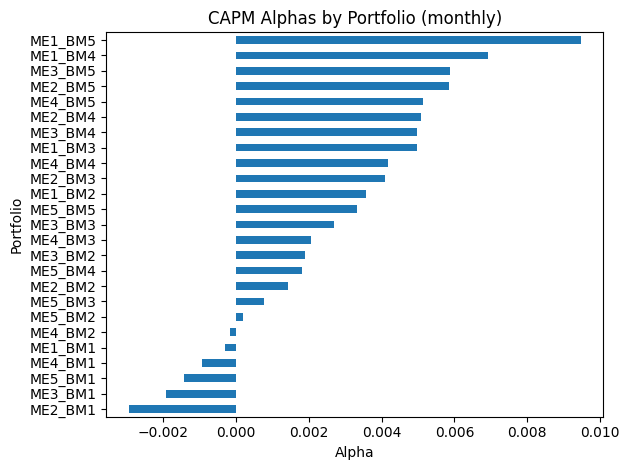

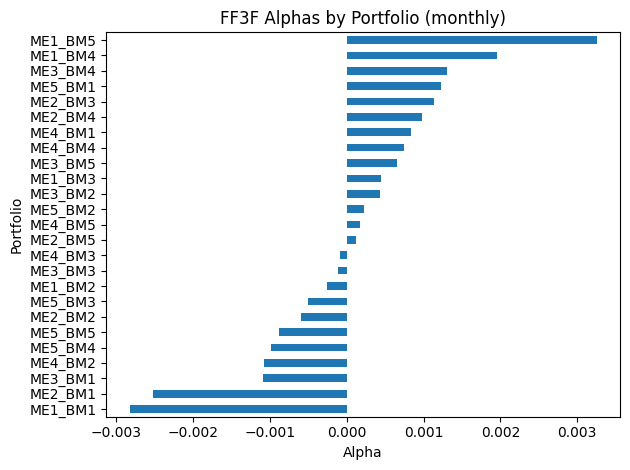

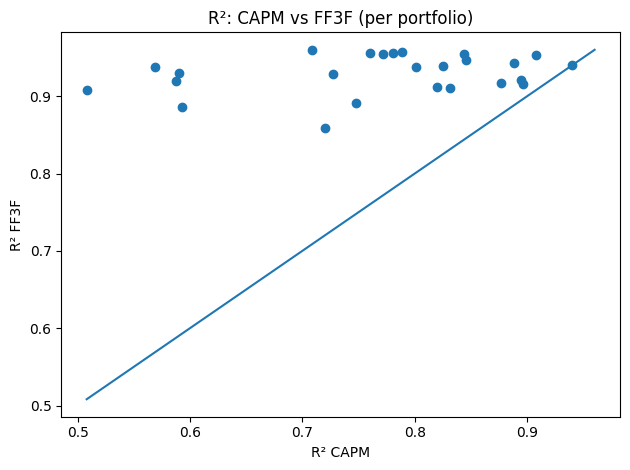

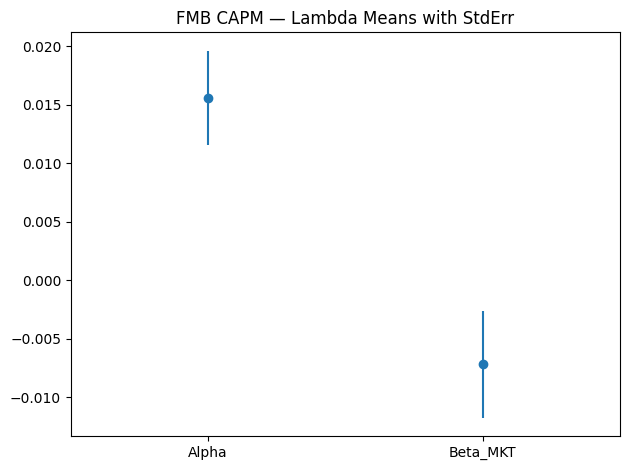

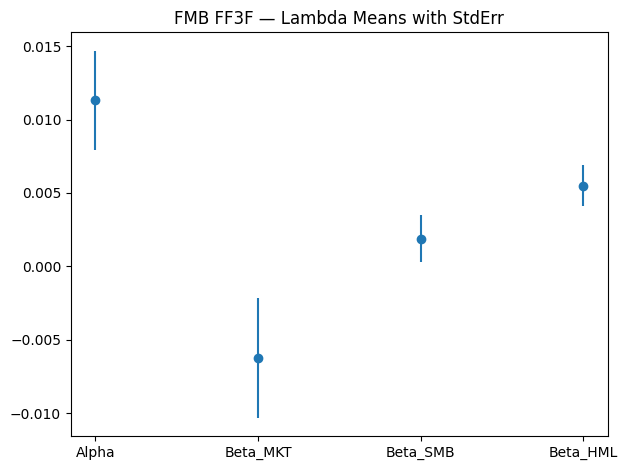

In [17]:
def run_model(model, sample, port_cols, excess, CAPM_L, FF3_L):
    desc_table_monthly, desc_table_yearly = calculate_descriptive_statistics(sample, port_cols, excess, use_raw_for_descriptives=False)
    print("Descriptive Statistics of Portfolios (Yearly):")
    display(desc_table_yearly)
    print()
    print("Descriptive Statistics of Portfolios (Monthly):")
    display(desc_table_monthly)
    print()

    capm_table = capm_summary = f_cov_capm = Sigma_e_capm = fmb_capm_summary = fmb_capm_summary_shanken = agg_capm = None
    ff3_table = ff3_summary = f_cov_ff3 = Sigma_e_ff3 = fmb_ff3_summary = fmb_ff3_summary_shanken = agg_ff3 = None

    if model in ("CAPM", "Both"):
        capm_table, capm_summary, f_cov_capm, Sigma_e_capm = run_capm_regression(sample, port_cols, excess, CAPM_L)
        print("CAPM Regression Results:")
        display(capm_table)
        print()
        print("CAPM GRS Test Summary:")
        display(capm_summary)
        print()

        fmb_capm_summary = fmb_procedure(excess, capm_table[["Beta_MKT"]])
        # print(fmb_capm_summary, '\n')
        fmb_capm_summary_shanken = shanken_correction(fmb_capm_summary, sample[["RMRF"]])
        # print(fmb_capm_summary_shanken, '\n')

        agg_capm = aggregate_results(fmb_capm_summary, fmb_capm_summary_shanken)
        print("FMB CAPM Summary (with Shanken correction):")
        display(agg_capm)
        print()

    if model in ("FF3F", "Both"):
        ff3_table, ff3_summary, f_cov_ff3, Sigma_e_ff3 = run_ff3f_regression(sample, port_cols, excess, FF3_L)
        print("FF3F Regression Results:")
        display(ff3_table)
        print()
        print("FF3F GRS Test Summary:")
        display(ff3_summary)
        print()

        fmb_ff3_summary = fmb_procedure(excess, ff3_table[["Beta_MKT", "Beta_SMB", "Beta_HML"]])
        # print(fmb_ff3_summary, '\n')
        fmb_ff3_summary_shanken = shanken_correction(fmb_ff3_summary, sample[["RMRF","SMB","HML"]])
        # print(fmb_ff3_summary_shanken, '\n')

        agg_ff3 = aggregate_results(fmb_ff3_summary, fmb_ff3_summary_shanken)
        print("FMB FF3F Summary (with Shanken correction):")
        display(agg_ff3)
        print()
    
    chart_outputs = {}
    if model in ("CAPM", "Both"):
        chart_outputs["plot_capm_alpha_bars"] = plot_capm_alpha_bars(capm_table)

    if model in ("FF3F", "Both"):
        chart_outputs["plot_ff3f_alpha_bars"] = plot_ff3f_alpha_bars(ff3_table)

    if model == "Both":
        chart_outputs["plot_r2_scatter_capm_vs_ff3f"] = plot_r2_scatter_capm_vs_ff3f(capm_table, ff3_table)
        chart_outputs["plot_fmb_capm_lambdas"] = plot_fmb_capm_lambdas(fmb_capm_summary)
        chart_outputs["plot_fmb_ff3f_lambdas"] = plot_fmb_ff3f_lambdas(fmb_ff3_summary)

    return {
        "desc_table_monthly": desc_table_monthly,
        "desc_table_yearly": desc_table_yearly,
        "capm_table": capm_table,
        "capm_summary": capm_summary,
        "f_cov_capm": f_cov_capm,
        "Sigma_e_capm": Sigma_e_capm,
        "agg_capm": agg_capm,
        "ff3_table": ff3_table,
        "ff3_summary": ff3_summary,
        "f_cov_ff3": f_cov_ff3,
        "Sigma_e_ff3": Sigma_e_ff3,
        "agg_ff3": agg_ff3,
        "charts": chart_outputs
    }

results = run_model(model, sample, port_cols, excess, CAPM_L, FF3_L)

In [18]:
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl import Workbook
from openpyxl.styles import Alignment, Font
from openpyxl.utils import get_column_letter
from openpyxl.drawing.image import Image as XLImage

def file_name_export(model, start, end):
    # Format dates as 'YYYYMMDD'
    start_str = start.strftime('%Y%m')
    end_str = end.strftime('%Y%m')
    if model == "Both":
        model_part = "CAPM_FF3F"
    elif model == "CAPM":
        model_part = "CAPM"
    elif model == "FF3F":
        model_part = "FF3F"
    else:
        raise ValueError("Invalid model")
    return f"analysis_report_{model_part}_{start_str}_{end_str}.xlsx"


def export_to_excel(filename, input_info, results, charts=None):
    """
    Export all analysis results to a formatted Excel workbook.

    Parameters:
    - filename: output Excel file path
    - input_info: dict with input specs (date range, model, etc.)
    - results: dict with DataFrames of analysis results, e.g. 
      'desc_table_monthly', 'capm_table', 'capm_summary', 'f_cov_capm', 'Sigma_e_capm', 
      'fmb_capm_summary', 'fmb_capm_summary_shanken', 'agg_capm',
      'ff3_table', 'ff3_summary', 'f_cov_ff3', 'Sigma_e_ff3',
      'fmb_ff3_summary', 'fmb_ff3_summary_shanken', 'agg_ff3'
    - charts: optional dict of matplotlib figures keyed by sheet/figure name

    Produces an Excel workbook with main summary tab, exhibits, covariances, GRS tests,
    Fama-MacBeth results and diagnostic charts if present.
    """

    input_info["model"] = "CAPM/FF3F" if model == "Both" else model

    def write_df(ws, df, title=None, start_row=1):
        if title:
            ws.cell(row=start_row, column=1, value=title)
            ws.cell(row=start_row, column=1).font = Font(bold=True, size=14)
            start_row += 2
        for r_idx, row in enumerate(dataframe_to_rows(df, index=True, header=True), start_row):
            for c_idx, value in enumerate(row, 1):
                cell = ws.cell(row=r_idx, column=c_idx, value=value)
                if r_idx == start_row:
                    cell.font = Font(bold=True)
                cell.alignment = Alignment(horizontal="center", vertical="center")

    wb = Workbook()
    ws_summary = wb.active
    ws_summary.title = "Main Summary"

    for col in range(1, 20):
        ws_summary.column_dimensions[get_column_letter(col)].width = 20
    
    # Input information
    ws_summary.cell(row=1, column=1, value="Input Information and Model Specifications")
    ws_summary.cell(row=1, column=1).font = Font(bold=True, size=14)
    row_cursor = 3
    for k, v in input_info.items():
        ws_summary.cell(row=row_cursor, column=1, value=k)
        ws_summary.cell(row=row_cursor, column=2, value=str(v))
        row_cursor += 1
    row_cursor += 1
    
    # Descriptive statistics
    if results.get('desc_table_yearly') is not None:
        write_df(ws_summary, results['desc_table_yearly'], title="Portfolio Descriptive Statistics (Yearly)", start_row=row_cursor)
        row_cursor += results['desc_table_yearly'].shape[0] + 5

    # CAPM tables and summaries
    if results.get('capm_table') is not None:
        write_df(ws_summary, results['capm_summary'], title="CAPM Summary Statistics", start_row=row_cursor)
        row_cursor += results['capm_summary'].shape[0] + 5
        write_df(ws_summary, results['agg_capm'], title="FMB CAPM Risk Premia", start_row=row_cursor)
        row_cursor += results['agg_capm'].shape[0] + 5

    # FF3F tables and summaries
    if results.get('ff3_table') is not None:
        write_df(ws_summary, results['ff3_summary'], title="FF3F Summary Statistics", start_row=row_cursor)
        row_cursor += results['ff3_summary'].shape[0] + 5
        write_df(ws_summary, results['agg_ff3'], title="FMB FF3F Risk Premia", start_row=row_cursor)
        row_cursor += results['agg_ff3'].shape[0] + 5

    # Portfolio summary tab
    ws_portfolio = wb.create_sheet("Portfolio Summary")
    for col in range(1, 20):
        ws_portfolio.column_dimensions[get_column_letter(col)].width = 15
    row_cursor = 1
    if results.get('desc_table_yearly') is not None:
        write_df(ws_portfolio, results['desc_table_yearly'], title="Portfolio Descriptive Statistics (Yearly)", start_row=row_cursor)
        row_cursor += results['desc_table_yearly'].shape[0] + 5
    if results.get('desc_table_monthly') is not None:
        write_df(ws_portfolio, results['desc_table_monthly'], title="Portfolio Descriptive Statistics (Monthly)", start_row=row_cursor)
        row_cursor += results['desc_table_monthly'].shape[0] + 5

    # Regression Outputs tab
    ws_regression = wb.create_sheet("Regression Outputs")
    # Make cell widths wider for readability
    for col in range(1, 20):
        ws_regression.column_dimensions[get_column_letter(col)].width = 15
    row_cursor = 1
    if results.get('capm_table') is not None:
        write_df(ws_regression, results['capm_table'], title="CAPM Regression Results", start_row=row_cursor)
        row_cursor += results['capm_table'].shape[0] + 5
    if results.get('ff3_table') is not None:
        write_df(ws_regression, results['ff3_table'], title="FF3F Regression Results", start_row=row_cursor)
        row_cursor += results['ff3_table'].shape[0] + 5

    # Residual & Factor Covariance tab
    ws_cov = wb.create_sheet("Covariance Matrices")
    for col in range(1, 30):
        ws_cov.column_dimensions[get_column_letter(col)].width = 15
    row_cursor = 1
    if results.get('Sigma_e_capm') is not None:
        write_df(ws_cov, pd.DataFrame(results['Sigma_e_capm']), title="CAPM Residual Covariance", start_row=row_cursor)
        row_cursor += results['Sigma_e_capm'].shape[0] + 5
    if results.get('f_cov_capm') is not None:
        write_df(ws_cov, pd.DataFrame(results['f_cov_capm']), title="CAPM Factor Covariance", start_row=row_cursor)
        row_cursor += results['f_cov_capm'].shape[0] + 5
    if results.get('Sigma_e_ff3') is not None:
        write_df(ws_cov, pd.DataFrame(results['Sigma_e_ff3']), title="FF3F Residual Covariance", start_row=row_cursor)
        row_cursor += results['Sigma_e_ff3'].shape[0] + 5
    if results.get('f_cov_ff3') is not None:
        write_df(ws_cov, pd.DataFrame(results['f_cov_ff3']), title="FF3F Factor Covariance", start_row=row_cursor)
        row_cursor += results['f_cov_ff3'].shape[0] + 5

    # GRS test components tab
    ws_grs = wb.create_sheet("GRS Test Outputs")
    for col in range(1, 20):
        ws_grs.column_dimensions[get_column_letter(col)].width = 15
    row_cursor = 1
    if results.get('capm_summary') is not None: 
        # capm_summary.reset_index(inplace=True)
        write_df(ws_grs, results['capm_summary'], title="CAPM GRS Test Summary", start_row=row_cursor)
        row_cursor += results['capm_summary'].shape[0] + 5
    if results.get('ff3_summary') is not None:
        # ff3_summary.reset_index(inplace=True)
        write_df(ws_grs, results['ff3_summary'], title="FF3F GRS Test Summary", start_row=row_cursor)
        row_cursor += results['ff3_summary'].shape[0] + 5

    # Fama–MacBeth tabs
    ws_fmb = wb.create_sheet("FMB Outputs")
    for col in range(1, 20):
        ws_fmb.column_dimensions[get_column_letter(col)].width = 20
    row_cursor = 1
    if results.get('agg_capm') is not None:
        write_df(ws_fmb, results['agg_capm'], title="FMB CAPM Summary", start_row=row_cursor)
        row_cursor += results['agg_capm'].shape[0] + 5
    if results.get('agg_ff3') is not None:
        write_df(ws_fmb, results['agg_ff3'], title="FMB FF3F Summary", start_row=row_cursor)
        row_cursor += results['agg_ff3'].shape[0] + 5

    if results.get('charts') is not None:
        ws_chart = wb.create_sheet("Charts")
        top_left_cell_row = 1
        img_files = []

        for chart_name, fig in results['charts'].items():
            img_path = f"_temp_{chart_name}.png"
            fig.savefig(img_path, bbox_inches='tight')
            img_files.append((img_path, chart_name))
        
        for img_path, chart_name in img_files:
            img = XLImage(img_path)
            cell_position = f"A{top_left_cell_row}"
            ws_chart.add_image(img, cell_position)
            img_height = img.height if img.height else 200
            rows_to_advance = max(img_height // 20, 15)
            top_left_cell_row += rows_to_advance

    wb.save(filename)
    print(f"Excel report saved to: {filename}")

    # Now all images inserted, safely delete files
    for img_path, _ in img_files:
        os.remove(img_path)


file_name = file_name_export(model, start, end)
input_info = {
    "model": model,
    "start": start,
    "end": end
}

export_to_excel(file_name, input_info, results)

Excel report saved to: analysis_report_CAPM_FF3F_196301_199312.xlsx
